#### Load necessary packages

In [25]:
import numpy as np
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Load CMIP6 training data

In [26]:
with open('../data/cmip6_random_samples.pkl', 'rb') as f:
    cmip6_random_samples = pickle.load(f)

#### Transform mon to mon_sin and mon_cos

In [27]:
cmip6_random_samples["mon_sin"] = np.sin(cmip6_random_samples["mon"] / 12 * 2 * np.pi)
cmip6_random_samples["mon_cos"] = np.cos(cmip6_random_samples["mon"] / 12 * 2 * np.pi)
del cmip6_random_samples["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [28]:
cmip6_random_samples["nvector1"] = np.sin(cmip6_random_samples["lat"] / 360 * 2 * np.pi)
cmip6_random_samples["nvector2"] = np.sin(cmip6_random_samples["lon"] / 360 * 2 * np.pi)\
* np.cos(cmip6_random_samples["lat"] / 360 * 2 * np.pi)
cmip6_random_samples["nvector3"] = - np.cos(cmip6_random_samples["lon"] / 360 * 2 * np.pi)\
* np.cos(cmip6_random_samples["lat"] / 360 * 2 * np.pi)
del cmip6_random_samples["lon"]
del cmip6_random_samples["lat"]

In [29]:
df = pd.DataFrame(cmip6_random_samples)
print(df)

           talkos  dissicos        tos        sos          sios         po4os  \
0        0.002300  0.002075  14.205753  33.903896  1.275010e-05  1.933323e-08   
1        0.002299  0.001981  26.818392  34.373871  9.919313e-09  8.624555e-09   
2        0.002260  0.001934  27.420202  33.745064  5.357209e-08  7.909007e-08   
3        0.002324  0.002038  29.089867  34.708054  7.142363e-06  6.850541e-07   
4        0.002287  0.002104   8.901377  33.684261  2.263223e-05  6.110404e-07   
...           ...       ...        ...        ...           ...           ...   
5999995  0.002195  0.001886  28.419693  33.151085  2.099906e-07  1.963973e-07   
5999996  0.002301  0.002002  19.004026  35.086674  6.228225e-07  2.802442e-07   
5999997  0.002101  0.001810  28.489004  30.891163  4.541886e-07  9.149397e-10   
5999998  0.002292  0.002150  -0.870190  33.540627  8.180652e-05  1.530746e-06   
5999999  0.002307  0.001977  24.939692  35.061729  2.198318e-07  2.191912e-07   

            mlotst       zo

#### Normalize talkos, dissicos, tos, sos, sios, and po4os

In [30]:
alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

sample_means = {"talkos":(alk_range[0] + alk_range[1]) / 2,
                 "dissicos":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tos":(tem_range[0] + tem_range[1]) / 2,
                 "sos":(sal_range[0] + sal_range[1]) / 2,
                 "sios":(sil_range[0] + sil_range[1]) / 2,
                 "po4os":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"talkos":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dissicos":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tos":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sos":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sios":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "po4os":(phos_range[1] - phos_range[0]) / np.sqrt(12)}

label_keys = ["talkos", "dissicos", "sios", "po4os"]
for key in label_keys:
    cmip6_random_samples[key] = (
        cmip6_random_samples[key] - sample_means[key]) / sample_stds[key]

#### Do KS test to see which variables should be log-transformed

In [31]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas",
                "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

In [32]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

In [33]:
print("mlotst statistic: ",
      stats.kstest(normalize(cmip6_random_samples["mlotst"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform: ",
      stats.kstest(normalize(np.log(cmip6_random_samples["mlotst"])), stats.norm.cdf)[0])

mlotst statistic:  0.2567800157729451
mlotst statistic with log transform:  0.018253479048485066


In [34]:
print("chlos statistic: ",
      stats.kstest(normalize(cmip6_random_samples["chlos"]), stats.norm.cdf)[0])
print("chlos statistic with log transform: ",
      stats.kstest(normalize(np.log(cmip6_random_samples["chlos"])), stats.norm.cdf)[0])

chlos statistic:  0.33018389805163467
chlos statistic with log transform:  0.06382566488574154


Text(0.5, 1.0, 'mlotst')

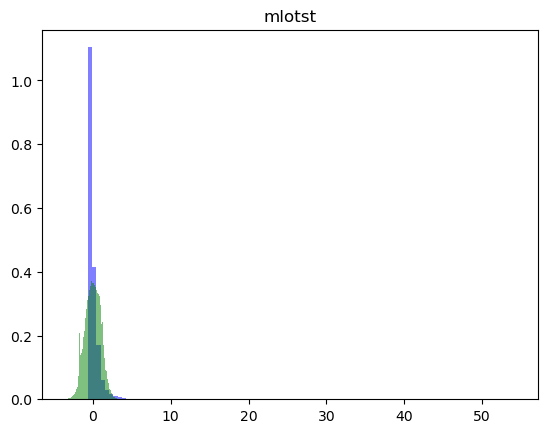

In [35]:
plt.hist(normalize(cmip6_random_samples["mlotst"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(cmip6_random_samples["mlotst"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("mlotst")

Text(0.5, 1.0, 'chlos')

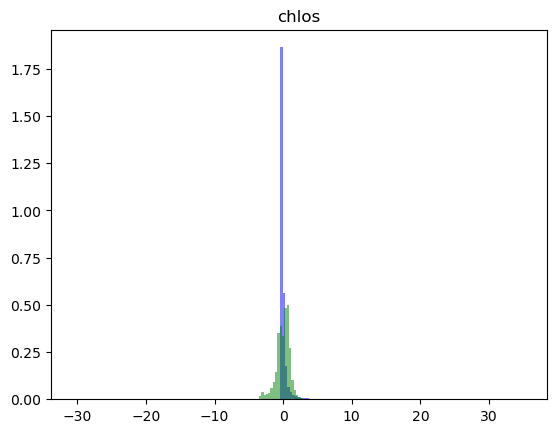

In [36]:
plt.hist(normalize(cmip6_random_samples["chlos"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(cmip6_random_samples["chlos"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("chlos")

In [37]:
log_transform_keys = ["mlotst", "chlos"]
for key in log_transform_keys:
    cmip6_random_samples[key] = np.log(cmip6_random_samples[key])

####  Split into training and validation sets,
#### normalize data and convert into feature and label arrays

In [38]:
#np.random.seed(0)
random.seed(0)
nsamples = 6000_000
ntrain = 5000_000

random_indices = np.arange(nsamples, dtype=int)
random.shuffle(random_indices)

train_samples = {key: cmip6_random_samples[key][random_indices][:ntrain]
                 for key in cmip6_random_samples}
valid_samples = {key: cmip6_random_samples[key][random_indices][ntrain:]
                 for key in cmip6_random_samples}

In [39]:
train_feature_means = {key: np.mean(train_samples[key]) for key in feature_keys}
train_feature_stds = {key: np.std(train_samples[key]) for key in feature_keys}

train_features = np.concatenate([(
    train_samples[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

valid_features = np.concatenate([(
    valid_samples[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

train_labels = np.concatenate([train_samples[key][:, np.newaxis]
                                 for key in label_keys],
                                          axis=1)

valid_labels = np.concatenate([valid_samples[key][:, np.newaxis]
                                 for key in label_keys],
                                          axis=1)

In [42]:
with open('../data/cmip6_base_model_train_feature_means.pkl', 'wb') as f:
    pickle.dump(train_feature_means, f)
with open('../data/cmip6_base_model_train_feature_stds.pkl', 'wb') as f:
    pickle.dump(train_feature_stds, f)

In [40]:
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

(5000000, 14)
(1000000, 14)
(5000000, 4)
(1000000, 4)


In [41]:
print("Verify that features are normalized.")
print(np.mean(train_features, axis=0))
print(np.std(train_features, axis=0))
print(np.mean(valid_features, axis=0))
print(np.std(valid_features, axis=0))

Verify that features are normalized.
[-3.46221832e-07 -1.51429291e-05 -3.02020573e-06 -2.64389372e-08
 -2.76868894e-06 -8.70409142e-08  1.47213594e-08 -1.05415506e-08
  4.47240089e-06 -1.48339498e-15  2.20232468e-15  1.61658247e-15
  1.73883807e-16  1.69341119e-16]
[1.00000018 1.00000023 0.99999999 0.99999995 0.99999973 1.00000001
 0.99999974 0.99999991 0.99999971 1.         1.         1.
 1.         1.        ]
[-0.00115049 -0.00235968 -0.00216672 -0.00143924 -0.00160465  0.00152142
 -0.00066082  0.00173118 -0.00011664 -0.0012404   0.00135473  0.00077518
 -0.00042137  0.00055878]
[1.00060356 1.00169421 0.99852279 1.00027945 1.00320972 1.00169254
 0.99953222 1.00054428 1.00164282 1.00012921 0.99986925 1.00045422
 0.99974896 0.99948278]


#### Define neural network and training procedure

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2, device=self.device)
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3, device=self.device)
        self.linear4 = nn.Linear(hidden_size_3, output_size, device=self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = self.linear4(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [ ]:
model = MLP(14, 160, 160, 160, 4)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

In [ ]:
def training_dataloader(features, labels, batch_size):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")),
                   torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")))
                  for ind in batch_indices]
    return batch_data

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch
    
    training_data = training_dataloader(train_features,
                                        train_labels, batch_size)
    
    for batch in training_data:
        features, labels = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features))
        loss = loss_function(outputs, labels.to(torch.device("cuda")))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [ ]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, n_epochs, optimizer, scheduler):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    for epoch in pbar:

        model.train()

        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features.astype("float32"))))
            valid_loss_epoch = loss_function(
                valid_outputs, torch.from_numpy(valid_labels).to(torch.device("cuda"))
                                            ).detach().cpu().item()
        
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss':f'{train_loss_epoch:.3e}',
                          'valid_loss':f'{valid_loss_epoch:.3e}',
                          'learn_rate':f'{lr:.3e}'})

    return train_stats

#### Train neural network with pytorch

In [ ]:
batch_size = 1000
n_epochs = 10_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)

optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

In [ ]:
model.save("CMIP6_base_model_160x3_elu_10000epo.pth")

Text(0, 0.5, 'Mean squared error')

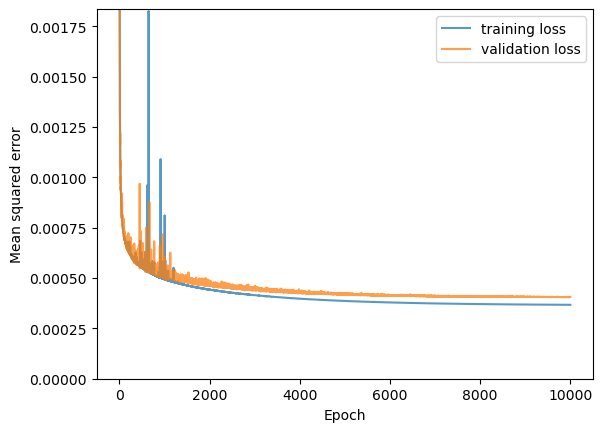

In [58]:
plt.plot(train_stats["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([0, train_stats["train_loss"][-1] * 5])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")

In [59]:
print("Valid loss at end of training close to overall minimum: {:.4e}".format(
    np.min(train_stats["valid_loss"])
))


Valid loss at end of training close to overall minimum: 4.0498e-04


In [60]:
sample_means_array = np.concatenate([np.array(sample_means[key])[np.newaxis]
                                     for key in label_keys], axis=0)
sample_stds_array = np.concatenate([np.array(sample_stds[key])[np.newaxis]
                                    for key in label_keys], axis=0)

def denormalize(array):
    return array * sample_stds_array + sample_means_array

In [61]:
print("Some tests of model performance")
print("Order:", "talkos", "dissicos", "sios", "po4os")
random_indices = np.random.randint(1000_000, size=10, dtype=int)

model.eval()
with torch.no_grad():
    for ind in random_indices:
        print("Index: ", ind)
        print(denormalize(valid_labels[ind]))
        print(denormalize(
            model(torch.from_numpy(valid_features[ind, :].astype("float32")
                                  )).detach().cpu().numpy()))
        print("-----")

Some tests of model performance
Order: talkos dissicos sios po4os
Index:  985772
[2.30561315e-03 2.17021428e-03 6.79250350e-05 1.68727287e-06]
[2.30169868e-03 2.17253259e-03 6.73909537e-05 1.68623721e-06]
-----
Index:  305711
[2.19498841e-03 1.86650997e-03 1.69328208e-07 3.74803086e-09]
[ 2.19496782e-03  1.87097228e-03  1.98960764e-07 -1.47365604e-09]
-----
Index:  435829
[2.25341494e-03 1.94677223e-03 1.97741385e-07 3.05231744e-07]
[2.24474883e-03 1.93990670e-03 1.59487954e-07 3.00916339e-07]
-----
Index:  117952
[2.26531213e-03 2.09214382e-03 2.21993638e-05 1.10349151e-06]
[2.26599527e-03 2.08868005e-03 2.22994871e-05 1.07546568e-06]
-----
Index:  963395
[2.25223734e-03 2.02239481e-03 7.43236326e-06 2.65633069e-07]
[2.25153389e-03 2.01747377e-03 7.50656754e-06 2.61020115e-07]
-----
Index:  152315
[2.18772656e-03 1.87801448e-03 4.48268691e-07 5.04830595e-08]
[2.18764239e-03 1.88949630e-03 1.30349851e-06 1.16818547e-07]
-----
Index:  882371
[2.03148686e-03 1.85564504e-03 6.17932401e-07

In [62]:
def MSE(x, y):
    return np.sum((x - y)**2, axis=0) / len(x)

In [63]:
model.eval()
with torch.no_grad():
    model_output_denormalized = denormalize(model(torch.from_numpy(
        valid_features.astype("float32"))).detach().cpu().numpy().squeeze())

valid_labels_denormalized = denormalize(valid_labels)

In [64]:
print("RMSE: talkos: {:.2e}, dissicos: {:.2e}, sios: {:.2e}, po4os: {:.2e}".format(
    *np.sqrt(MSE(model_output_denormalized, valid_labels_denormalized))))

RMSE: talkos: 6.10e-06, dissicos: 6.30e-06, sios: 8.23e-07, po4os: 3.38e-08


In [65]:
print("Max deviation: talkos: {:.2e}, dissicos: {:.2e}, sios: {:.2e}, po4os: {:.2e}".format(
    *np.max(np.abs(model_output_denormalized - valid_labels_denormalized), axis=0)))

Max deviation: talkos: 4.00e-04, dissicos: 4.34e-04, sios: 3.57e-05, po4os: 1.20e-06
